In [90]:
!nvidia-smi

Thu Jun  8 13:32:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    33W /  70W |    671MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# This is origin ref.
# https://machinelearningmastery.com/how-to-load-and-explore-household-electricity-usage-data/

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# Mounting the Google drive where we put the dataset, models and logs if needed 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load the dataset 

In [3]:
# Reading the dataset
working_dir = '/content/drive/MyDrive/work/lara/'
data_path= f"{working_dir}ALLYEAR.xlsx"
data = pd.read_excel(data_path)

In [119]:
# Visulize first five rows in the loaded dataset 
data.head()

,ElectricityTimesteps,Pump1,Pump2,Microwave,Fridge,WashingMachine,TV,Lights,TotalLoad
Time,,,,,,,,,
2021-01-01,1036080.0,35.960533,25.434819,36.0,13.599933,0.000000,15.742323,3.310974,130.048582
2021-01-02,65317680.0,36.047563,25.454741,36.0,13.599933,0.000000,15.718811,3.287561,130.108609
2021-01-03,123378480.0,36.012795,25.497593,36.0,13.599933,0.000000,15.757597,3.344934,130.212852
2021-01-04,187660080.0,36.140207,25.535769,36.0,13.599933,0.000000,15.609669,3.284917,130.170495
2021-01-05,249868080.0,35.975382,25.373283,36.0,13.599933,84.925036,15.590383,3.309143,214.773161


In [5]:
# Get column names
data.columns

Index(['Electricity Timesteps', 'Time', 'Pump1', 'Pump2', 'Microwave',
       'Fridge', 'WashingMachine', 'TV', 'Lights', 'TotalLoad'],
      dtype='object')

In [7]:
# Make vaild column names in camelcase format 
data.rename(columns={'Electricity Timesteps': 'ElectricityTimesteps',}, inplace=True) 
data.columns

Index(['ElectricityTimesteps', 'Time', 'Pump1', 'Pump2', 'Microwave', 'Fridge',
       'WashingMachine', 'TV', 'Lights', 'TotalLoad'],
      dtype='object')

In [8]:
data.set_index(['Time'], inplace=True)
data.head()

,ElectricityTimesteps,Pump1,Pump2,Microwave,Fridge,WashingMachine,TV,Lights,TotalLoad
Time,,,,,,,,,
'01/01/2021 00:00',0,0.023873,0.0,0.0,0.000000,0.0,0.0,0.0,0.023873
'01/01/2021 00:01',1,0.022895,0.0,0.0,0.003342,0.0,0.0,0.0,0.026237
'01/01/2021 00:02',2,0.022331,0.0,0.0,0.000000,0.0,0.0,0.0,0.022331
'01/01/2021 00:03',3,0.021684,0.0,0.0,0.000000,0.0,0.0,0.0,0.021684
'01/01/2021 00:04',4,0.031645,0.0,0.0,0.000000,0.0,0.0,0.0,0.031645


# Next, we can mark all missing values indicated with a ‘?‘ character with a NaN value, which is a float.

In [9]:
# We dont have data missing in the provided data but we need this step as the data have to be clean 
# Replacing each '?'characters with NaN value
data.replace('?', nan, inplace=True)

In [10]:
# This will allow us to work with the data as one array of floating point values rather than mixed types (less efficient.)
data = data.astype('float')

In [11]:
# Information of the dataset
# We can see now all the data type are float64 
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 525600 entries, '01/01/2021 00:00' to '31/12/2021 23:59'
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ElectricityTimesteps  525600 non-null  float64
 1   Pump1                 525600 non-null  float64
 2   Pump2                 525600 non-null  float64
 3   Microwave             525600 non-null  float64
 4   Fridge                525600 non-null  float64
 5   WashingMachine        525600 non-null  float64
 6   TV                    525600 non-null  float64
 7   Lights                525600 non-null  float64
 8   TotalLoad             525600 non-null  float64
dtypes: float64(9)
memory usage: 40.1+ MB


In [122]:
# Checking the null values
# Count how many null(means empty) values for each column
np.isnan(data).sum()

ElectricityTimesteps    0
Pump1                   0
Pump2                   0
Microwave               0
Fridge                  0
WashingMachine          0
TV                      0
Lights                  0
TotalLoad               0
dtype: int64

We also need to fill in the missing values now that they have been marked.

A very simple approach would be to copy the observation from the same time the day before. We can implement this in a function named fill_missing() that will take the NumPy array of the data and copy values from exactly 24 hours ago.

In [13]:
def fill_missing(data):
    one_day = 24*60
    for row in range(data.shape[0]):
        for col in range(data.shape[1]):
            if np.isnan(data[row, col]):
                data[row, col] = data[row-one_day, col]

In [14]:
# Call the function above 
fill_missing(data.values)

In [15]:
# checking the nan values
np.isnan(data).sum()

ElectricityTimesteps    0
Pump1                   0
Pump2                   0
Microwave               0
Fridge                  0
WashingMachine          0
TV                      0
Lights                  0
TotalLoad               0
dtype: int64

In [16]:
# Again chech for missing and we don have 
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 525600 entries, '01/01/2021 00:00' to '31/12/2021 23:59'
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ElectricityTimesteps  525600 non-null  float64
 1   Pump1                 525600 non-null  float64
 2   Pump2                 525600 non-null  float64
 3   Microwave             525600 non-null  float64
 4   Fridge                525600 non-null  float64
 5   WashingMachine        525600 non-null  float64
 6   TV                    525600 non-null  float64
 7   Lights                525600 non-null  float64
 8   TotalLoad             525600 non-null  float64
dtypes: float64(9)
memory usage: 40.1+ MB


In [123]:
# printing the shape of the data so, we have 365 rows and 9 columns 
data.shape

(365, 9)

Here, we can observe that we have 525600 datapoints and 9 features

In [18]:
data.head()

,ElectricityTimesteps,Pump1,Pump2,Microwave,Fridge,WashingMachine,TV,Lights,TotalLoad
Time,,,,,,,,,
'01/01/2021 00:00',0.0,0.023873,0.0,0.0,0.000000,0.0,0.0,0.0,0.023873
'01/01/2021 00:01',1.0,0.022895,0.0,0.0,0.003342,0.0,0.0,0.0,0.026237
'01/01/2021 00:02',2.0,0.022331,0.0,0.0,0.000000,0.0,0.0,0.0,0.022331
'01/01/2021 00:03',3.0,0.021684,0.0,0.0,0.000000,0.0,0.0,0.0,0.021684
'01/01/2021 00:04',4.0,0.031645,0.0,0.0,0.000000,0.0,0.0,0.0,0.031645


## Prepare power consumption for each day (This could be on Hour,Week ,Month and Year but more data is needed)
We can now save the cleaned-up version of the dataset to a new file; in this case we will just change the file extension to .csv and save the dataset as ‘cleaned_data.csv‘.

In [19]:
# Conversion of dataframe to .csv
data.to_csv(f'{working_dir}cleaned_data.csv')

In [21]:
# Reading the dataset
dataset = pd.read_csv(f'{working_dir}cleaned_data.csv', parse_dates = True, index_col = 'Time', low_memory = False) # date_time changed to Time 

In [22]:
# printing the top rows
dataset.head()

,ElectricityTimesteps,Pump1,Pump2,Microwave,Fridge,WashingMachine,TV,Lights,TotalLoad
Time,,,,,,,,,
2021-01-01 00:00:00,0.0,0.023873,0.0,0.0,0.000000,0.0,0.0,0.0,0.023873
2021-01-01 00:01:00,1.0,0.022895,0.0,0.0,0.003342,0.0,0.0,0.0,0.026237
2021-01-01 00:02:00,2.0,0.022331,0.0,0.0,0.000000,0.0,0.0,0.0,0.022331
2021-01-01 00:03:00,3.0,0.021684,0.0,0.0,0.000000,0.0,0.0,0.0,0.021684
2021-01-01 00:04:00,4.0,0.031645,0.0,0.0,0.000000,0.0,0.0,0.0,0.031645


In [23]:
# printing the bottom rows
dataset.tail()

,ElectricityTimesteps,Pump1,Pump2,Microwave,Fridge,WashingMachine,TV,Lights,TotalLoad
Time,,,,,,,,,
2021-12-31 23:55:00,525595.0,0.028258,0.0,0.0,0.0,0.0,0.0,0.0,0.028258
2021-12-31 23:56:00,525596.0,0.026433,0.0,0.0,0.0,0.0,0.0,0.0,0.026433
2021-12-31 23:57:00,525597.0,0.020795,0.0,0.0,0.0,0.0,0.0,0.0,0.020795
2021-12-31 23:58:00,525598.0,0.023843,0.0,0.0,0.0,0.0,0.0,0.0,0.023843
2021-12-31 23:59:00,525599.0,0.024154,0.0,0.0,0.0,0.0,0.0,0.0,0.024154


In [24]:
dataset.columns

Index(['ElectricityTimesteps', 'Pump1', 'Pump2', 'Microwave', 'Fridge',
       'WashingMachine', 'TV', 'Lights', 'TotalLoad'],
      dtype='object')

#Task: Exploratory Data Analysis(EDA)
I am using only Days based (D)
and you can play with others just remove the comment 

In [64]:
# Downsampling the data into dáy-wise bins and sum the values of the timestamps falling into a bin.
# Here I am donig resampling based on days
data = dataset.resample('D').sum()

In [ ]:
# # Here I am doing resampling based on Years as we have only one year 
# data_year = dataset.resample('Y').sum()
# data_year.head(20)

,ElectricityTimesteps,Pump1,Pump2,Microwave,Fridge,WashingMachine,TV,Lights,TotalLoad
Time,,,,,,,,,
2021-12-31,1.381274e+11,10009.107234,9308.164383,13140.0,4963.975641,8922.804149,5695.584881,1204.892669,53244.528958


In [ ]:
# # Sampling per second is not good here 
# data_ = dataset.resample('S').sum()
# data_.head()

,ElectricityTimesteps,Pump1,Pump2,Microwave,Fridge,WashingMachine,TV,Lights,TotalLoad
Time,,,,,,,,,
2021-01-01 00:00:00,0.0,0.023873,0.0,0.0,0.0,0.0,0.0,0.0,0.023873
2021-01-01 00:00:01,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2021-01-01 00:00:02,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2021-01-01 00:00:03,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2021-01-01 00:00:04,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [ ]:
# # Here I am doing resampling based on Months for one year(note that we have only one year here)
# data_month = dataset.resample('M').sum()
# data_month.head(20)

,ElectricityTimesteps,Pump1,Pump2,Microwave,Fridge,WashingMachine,TV,Lights,TotalLoad
Time,,,,,,,,,
2021-01-31,5.002538e+09,1008.771590,790.026239,1116.0,421.597931,685.047692,484.329867,102.270424,4608.043743
2021-02-28,5.872415e+09,935.559905,713.876033,1008.0,380.798131,774.004843,435.915337,92.647240,4340.801489
2021-03-31,7.376810e+09,1008.456068,790.656270,1116.0,421.597931,860.927193,483.208871,102.371113,4783.217446
2021-04-30,8.373175e+09,755.412298,765.188296,1080.0,407.997998,685.327324,468.418501,99.202381,4261.546798
2021-05-31,9.829878e+09,755.804555,790.562014,1116.0,421.597931,772.067058,483.505527,102.334666,4441.871752
2021-06-30,1.069975e+10,756.433989,765.339538,1080.0,407.997998,771.416513,467.257793,99.088290,4347.534123
2021-07-31,1.228295e+10,468.597333,791.077096,1116.0,421.597931,771.241258,485.172497,102.308891,4155.995007
2021-08-31,1.352918e+10,359.615037,790.521451,1116.0,421.597931,687.076062,482.799531,102.099394,3959.709407
2021-09-30,1.420829e+10,972.623444,764.774930,1080.0,407.997998,602.806201,467.184377,99.000805,4394.387755


In [65]:
# data after sampling it into daywise manner
data.head()

,ElectricityTimesteps,Pump1,Pump2,Microwave,Fridge,WashingMachine,TV,Lights,TotalLoad
Time,,,,,,,,,
2021-01-01,1036080.0,35.960533,25.434819,36.0,13.599933,0.000000,15.742323,3.310974,130.048582
2021-01-02,65317680.0,36.047563,25.454741,36.0,13.599933,0.000000,15.718811,3.287561,130.108609
2021-01-03,123378480.0,36.012795,25.497593,36.0,13.599933,0.000000,15.757597,3.344934,130.212852
2021-01-04,187660080.0,36.140207,25.535769,36.0,13.599933,0.000000,15.609669,3.284917,130.170495
2021-01-05,249868080.0,35.975382,25.373283,36.0,13.599933,84.925036,15.590383,3.309143,214.773161


### Plotting the all features in various time stamps

<ipython-input-66-1e16e12c7d9b>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(len(data.columns), 1, i+1)


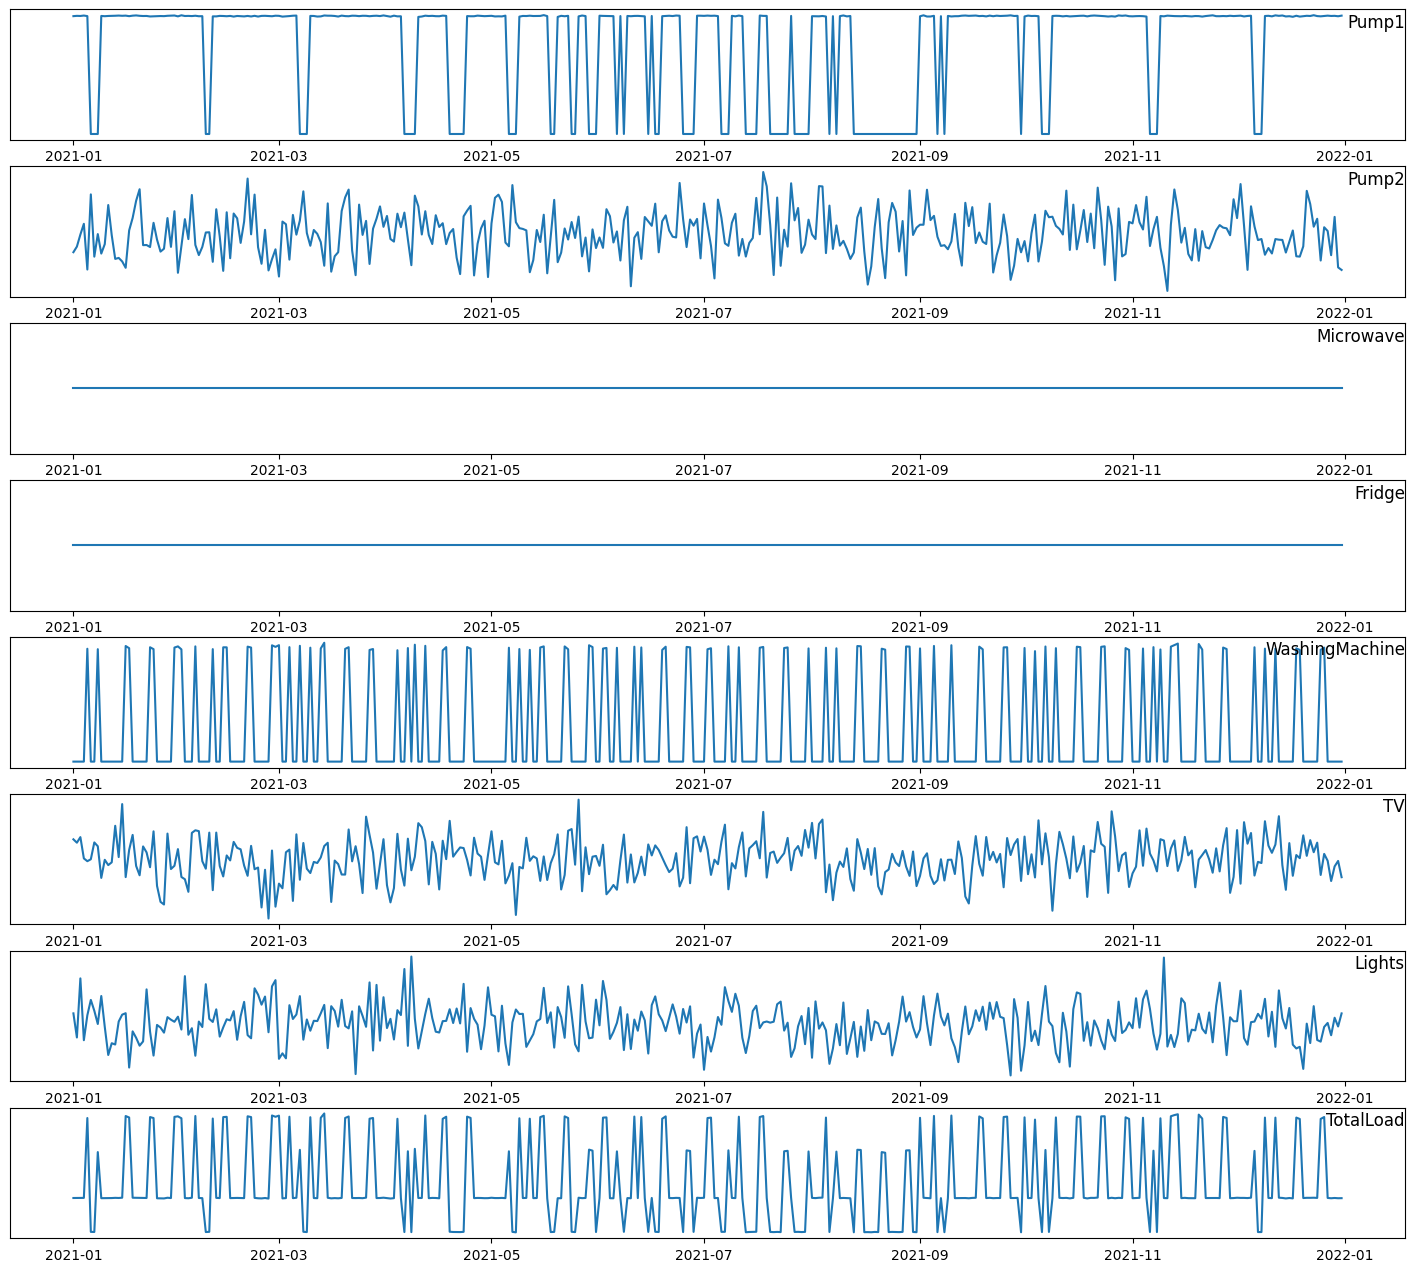

In [66]:
fig, ax = plt.subplots(figsize=(18,18))

for i in range(1,len(data.columns)): # Here we skip the first column as it is only show time steps  
    plt.subplot(len(data.columns), 1, i+1)
    name = data.columns[i]
    plt.plot(data[name])
    plt.title(name, y=0.8, loc = 'right')
    plt.yticks([])
plt.show()
fig.tight_layout()

###Exploring Active power consumption for each year

In [40]:
# Let us considere that  we have 5 years data collected 
# years = ['2020', '2021', '2022', '2023']
months = ['1','2','3','4','5','6','7','8','9','10','11','12']

### Year wise plotting of feature Washing Machine

In [41]:
years = ['2021']

<ipython-input-43-818b405598f3>:6: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  active_power_data = data[str(year)]


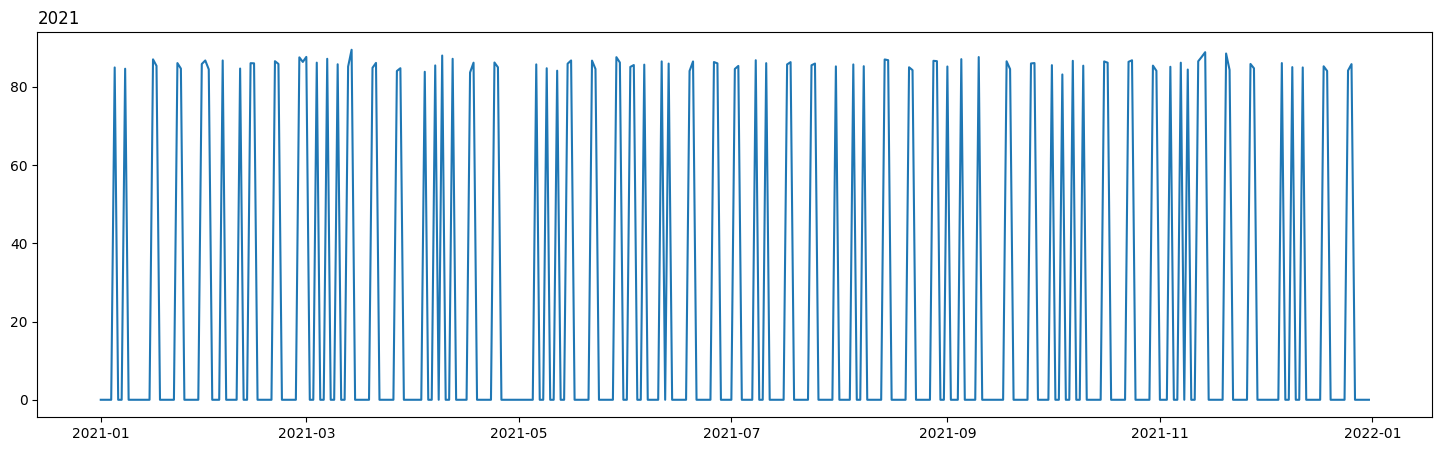

In [43]:
fig, ax = plt.subplots(figsize=(18,5))
for i in range(len(years)):
    plt.subplot(len(years), 1, i+1)
    year = years[i]
    active_power_data = data[str(year)]
    plt.plot(active_power_data['WashingMachine']) # Here we can change to any othere featuers such as : 'Pump1'
    plt.title(str(year), y = 1, loc = 'left')
plt.show()
fig.tight_layout()

<ipython-input-45-600515375538>:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  active_power_data = data[str(year)]


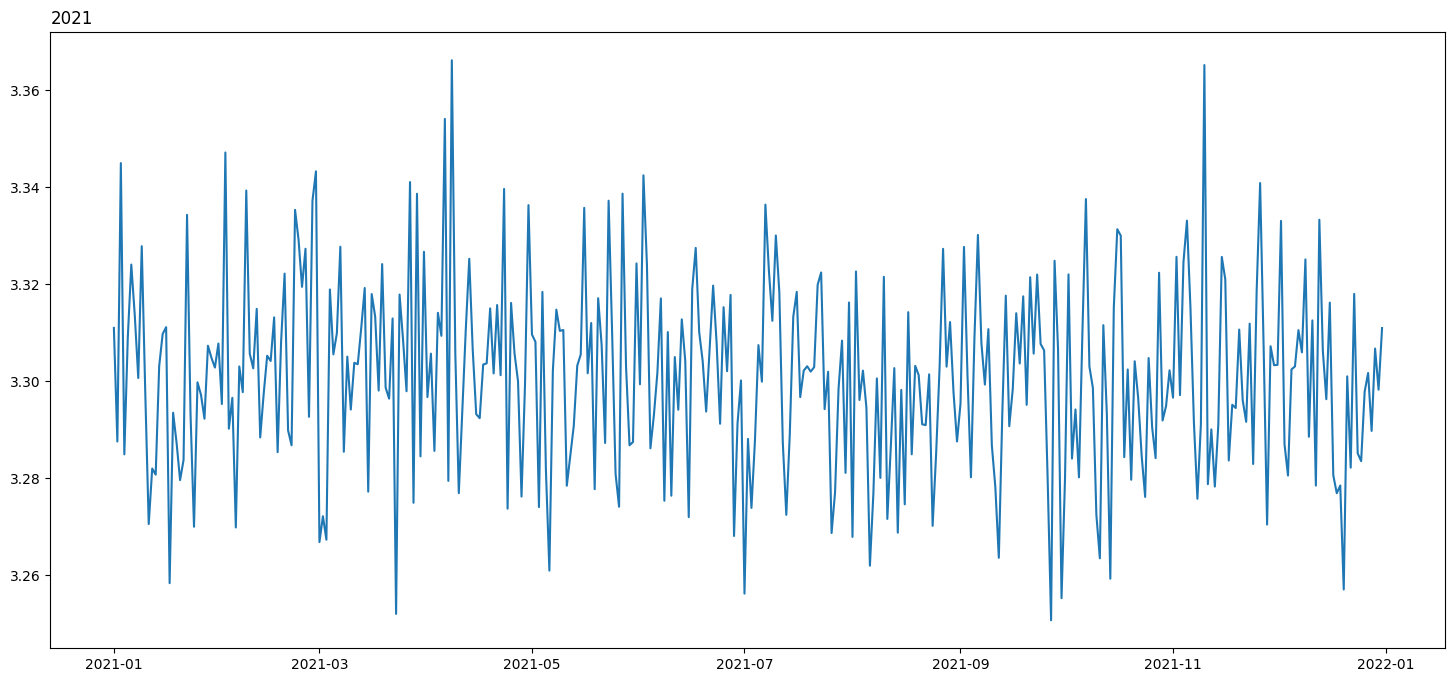

In [45]:
fig, ax = plt.subplots(figsize=(18,8))
for i in range(len(years)):
    plt.subplot(len(years), 1, i+1)
    year = years[i]
    active_power_data = data[str(year)]
    plt.plot(active_power_data['Lights'])
    plt.title(str(year), y = 1, loc = 'left')
plt.show()
fig.tight_layout()

###Power consumption distribution with histogram
Year wise histogram plot of feature Lights

<ipython-input-46-6bfe8e02bcce>:6: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  active_power_data = data[str(year)]


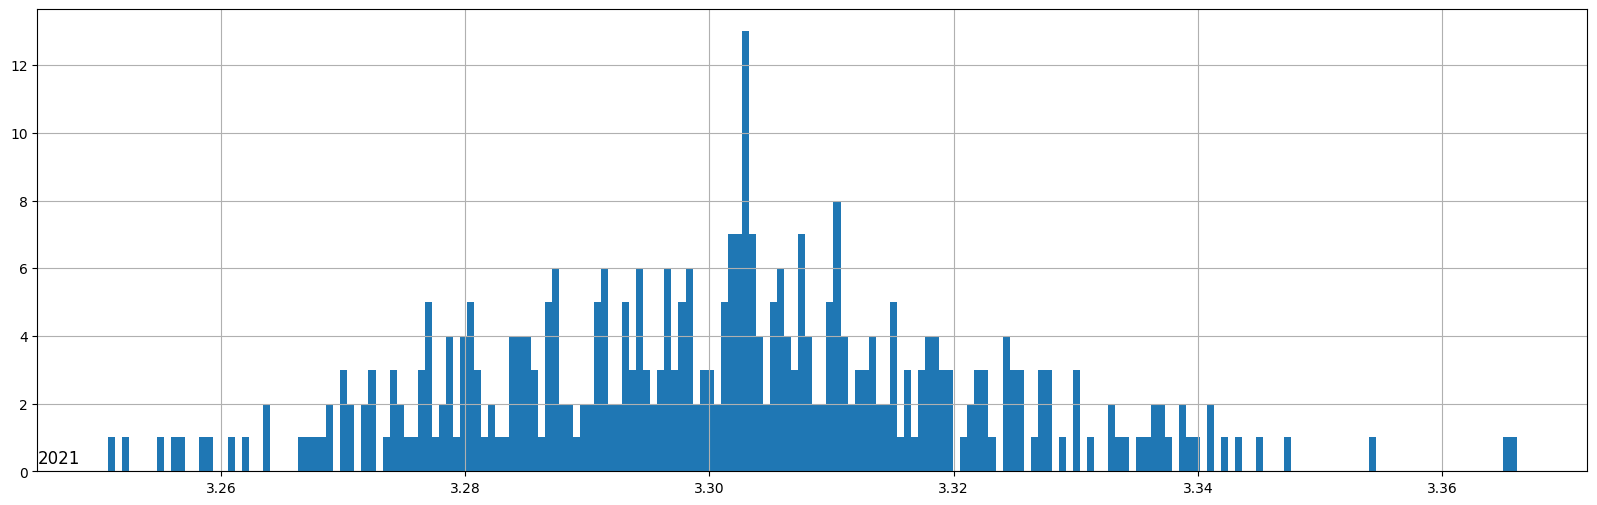

In [46]:
fig, ax = plt.subplots(figsize=(20,6))
for i in range(len(years)):
    plt.subplot(len(years), 1, i+1)
    year = years[i]
    active_power_data = data[str(year)]
    active_power_data['Lights'].hist(bins = 200)
    plt.title(str(year), y = 0, loc = 'left')
plt.show()
fig.tight_layout()

### Histogram plot for All Features

<ipython-input-48-ffa0ff3b9141>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(len(data.columns), 1, i+1)


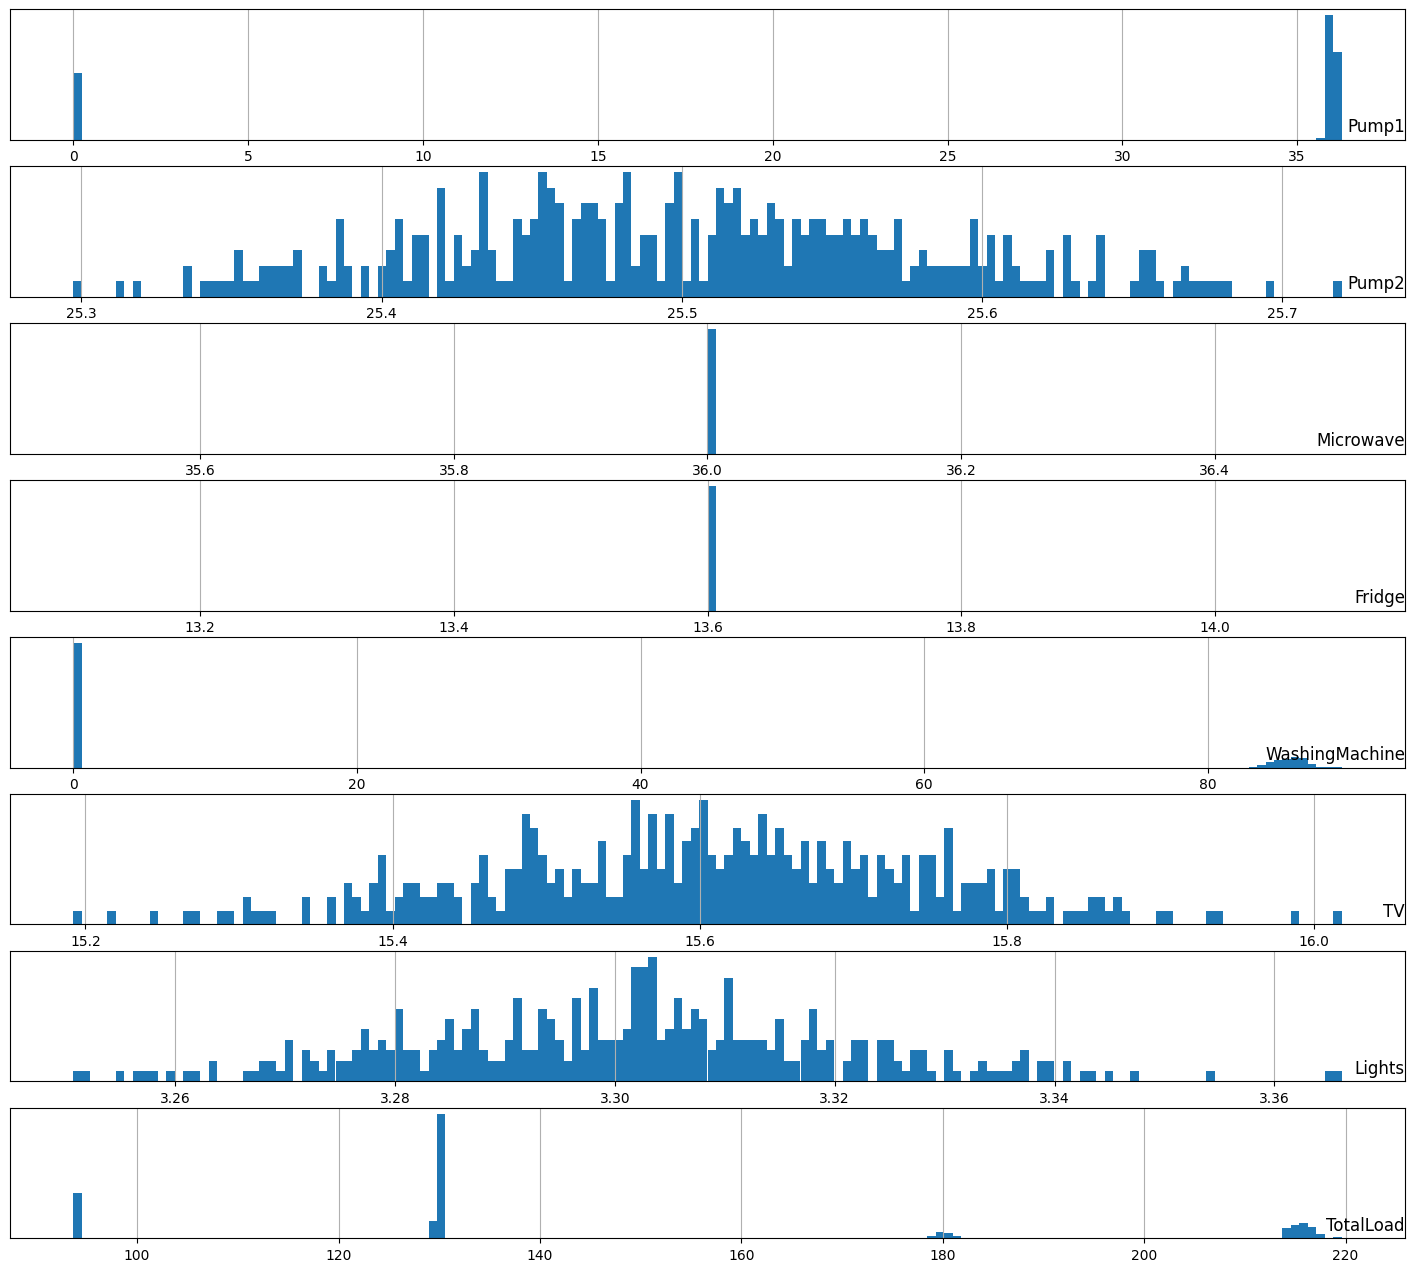

In [48]:
fig, ax = plt.subplots(figsize=(18,18))
for i in range(1,len(data.columns)):
    plt.subplot(len(data.columns), 1, i+1)
    name = data.columns[i]
    data[name].hist(bins=150)
    plt.title(name, y=0, loc = 'right')
    plt.yticks([])
plt.show()
fig.tight_layout()

## Plot power consumption hist for each month of 2021

<ipython-input-49-cba223ce78c2>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(len(months), 1, i+1)
<ipython-input-49-cba223ce78c2>:8: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  active_power_data = dataset[month]


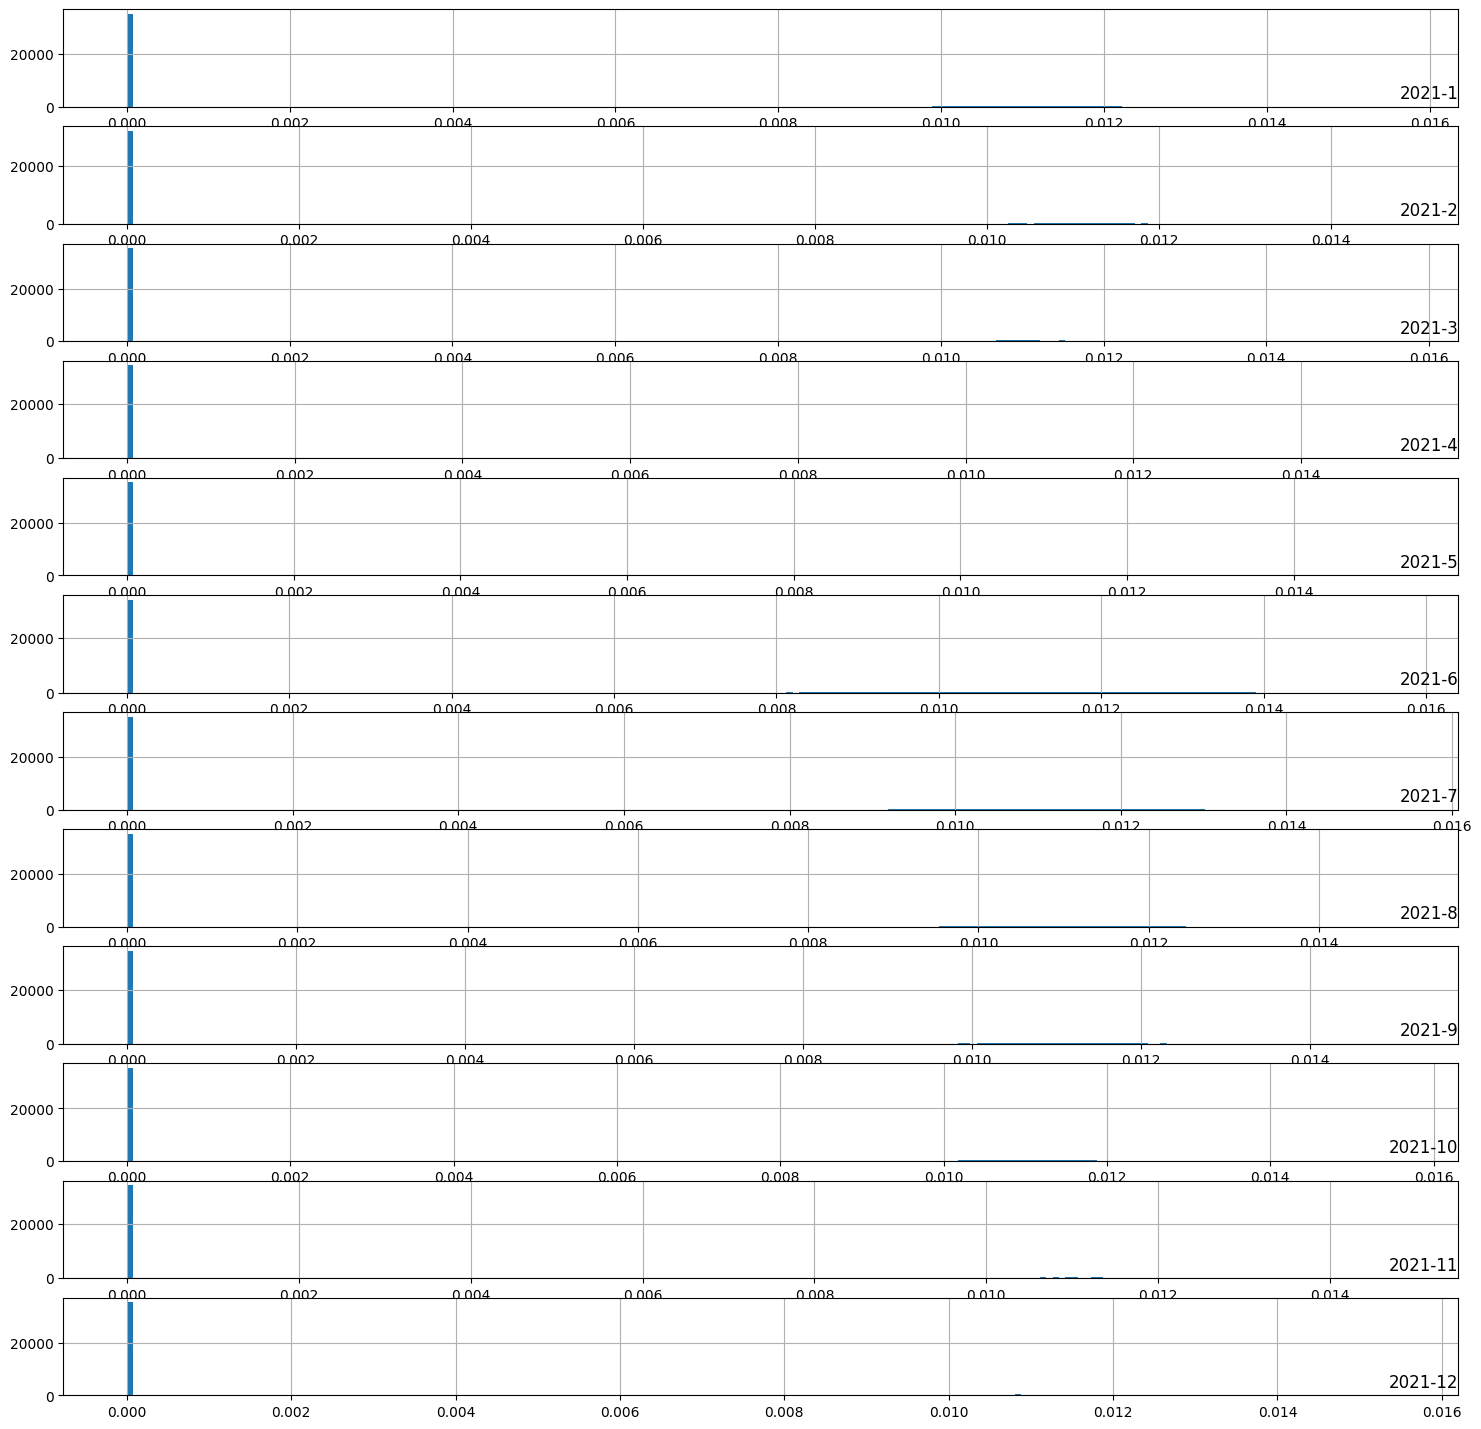

In [49]:
months = [i for i in range(1,13)] # here I need more data reading 
fig, ax = plt.subplots(figsize=(18,18))
for i in range(len(months)):
    ax = plt.subplot(len(months), 1, i+1)
    month = '2021-' + str(months[i])
    active_power_data = dataset[month]
    active_power_data['Lights'].hist(bins = 200)
    # ax.set_xlim(0,5)
    plt.title(month, y = 0, loc = 'right')
plt.show()
fig.tight_layout()

<ipython-input-50-db58dcf11664>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(len(months), 1, i+1)
<ipython-input-50-db58dcf11664>:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  active_power_data = dataset[month]


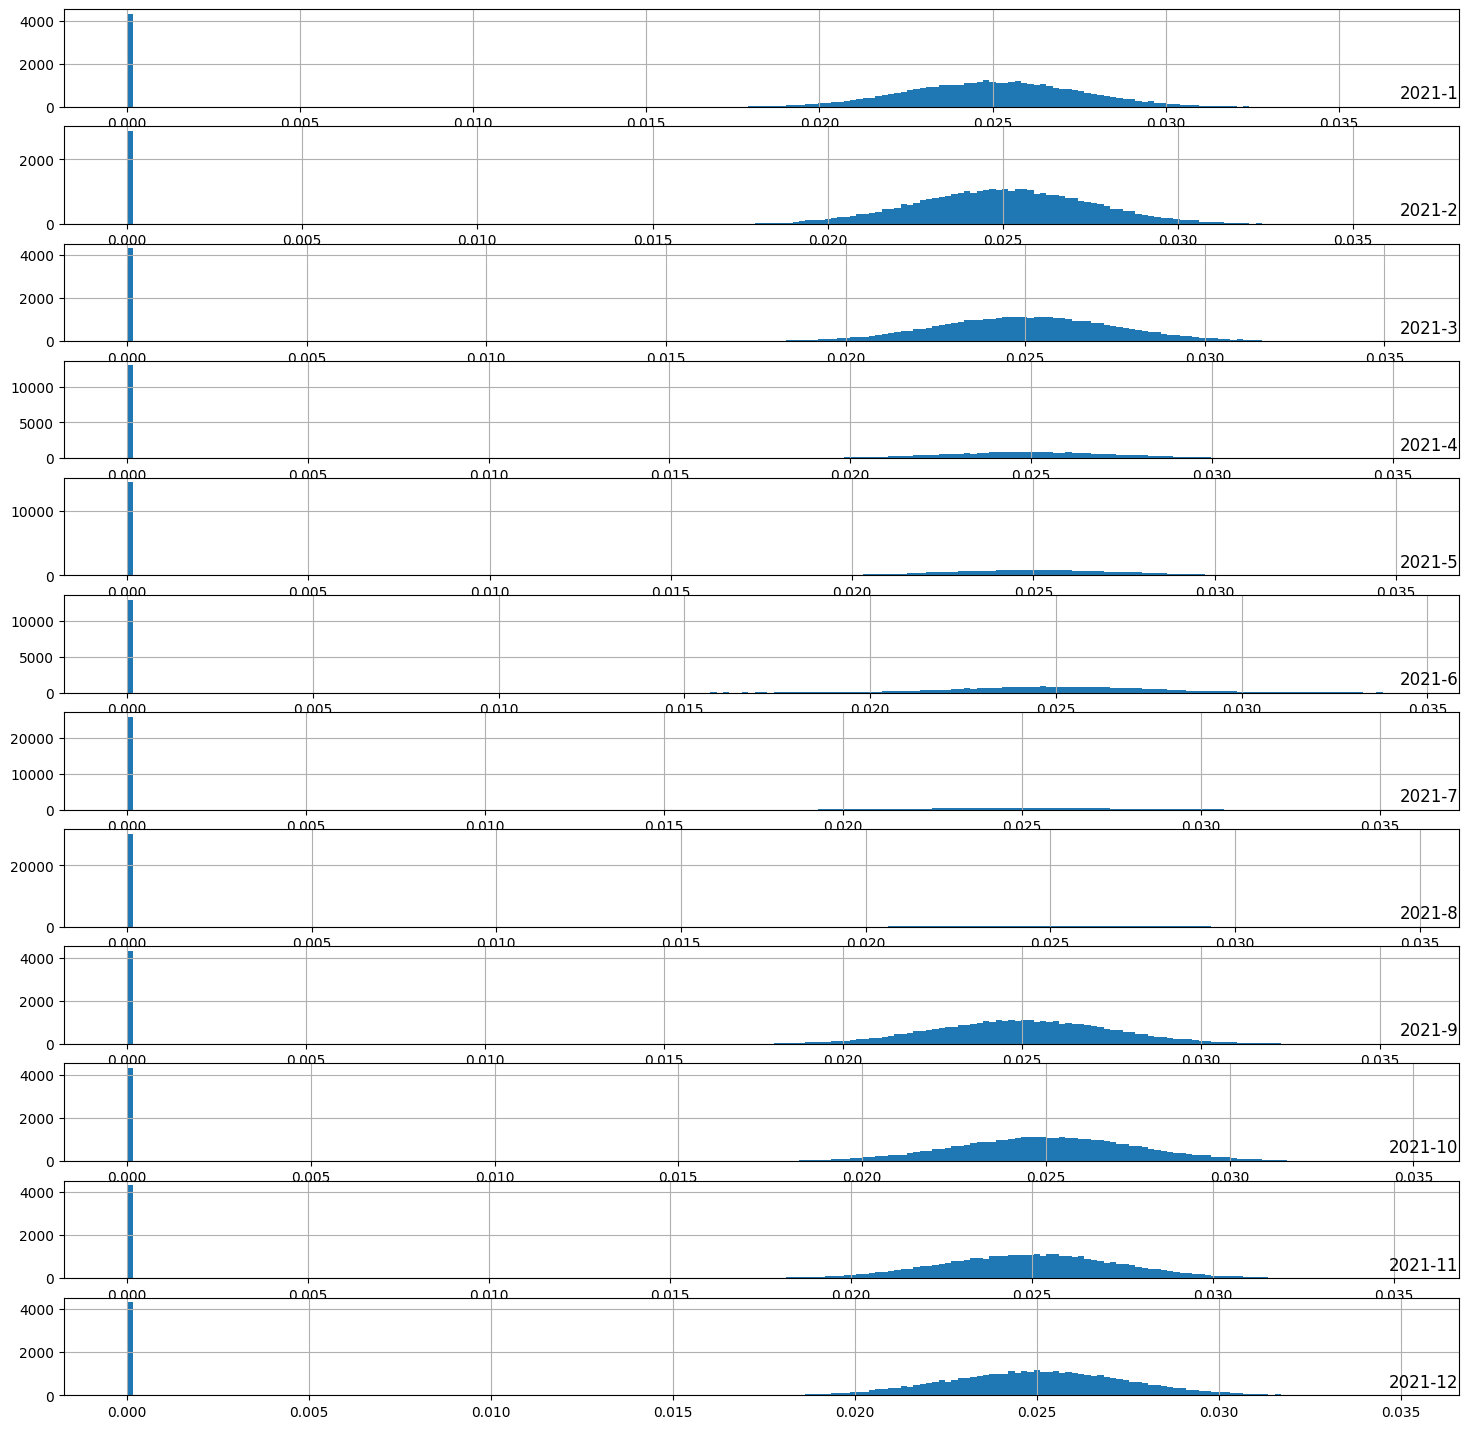

In [50]:
fig, ax = plt.subplots(figsize=(18,18))
for i in range(len(months)):
    ax = plt.subplot(len(months), 1, i+1)
    month = '2021-' + str(months[i])
    active_power_data = dataset[month]
    active_power_data['Pump1'].hist(bins = 200)
    # ax.set_xlim(0,5)
    plt.title(month, y = 0, loc = 'right')
plt.show()
fig.tight_layout()

<ipython-input-52-03860a9c2cb3>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot(len(months), 1, i+1)
<ipython-input-52-03860a9c2cb3>:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  active_power_data = dataset[month]


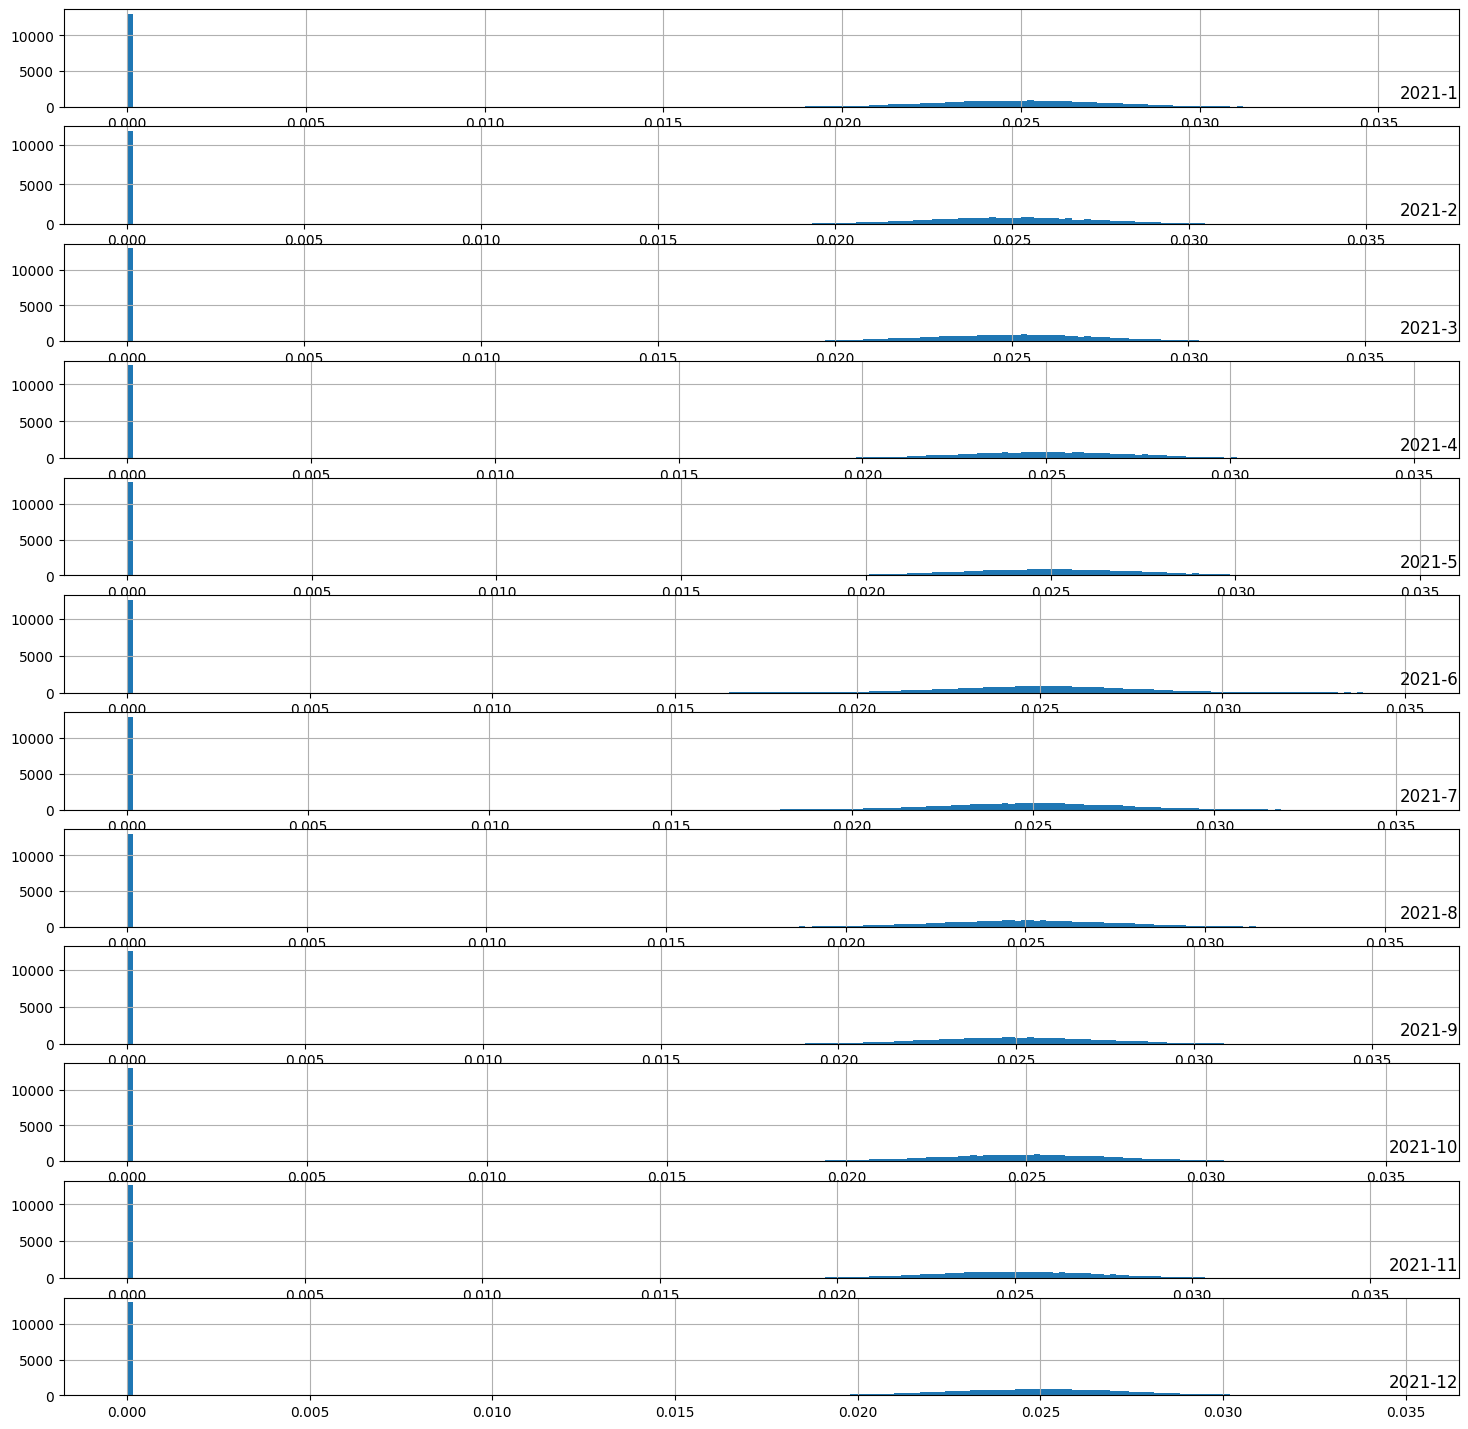

In [52]:
fig2, ax2 = plt.subplots(figsize=(18,18))
for i in range(len(months)):
    ax2 = plt.subplot(len(months), 1, i+1)
    month = '2021-' + str(months[i])
    active_power_data = dataset[month]
    active_power_data['Pump2'].hist(bins = 200)
    # ax.set_xlim(0,5)
    plt.title(month, y = 0, loc = 'right')
plt.show()
fig.tight_layout()

##Observation :
1. From the above diagram we can say that power consumption in the month of Nov, Dec, Jan, Feb, Mar is more as there is a long tail as compare to other months.
In other words, the Pump1 is used to much during 5,6, and 7 months to much while the Pump2 has been used as long as the year 
2. It also shows that the during the winter seasons, the Pumps system are not used and more used in summer.

3. The above graph is highly concentrated on 0.020W and 0.030W
4. the Fridge and Microwave has stable consumption as long as the year 

# Modeling Methods

### Machine Learning & Deep Learning :

* Select fatuers (you can choos others as will just rplece with 'Pump1' by 'Light' "e.g")
* Here we do spliting for dataset into train and test for evaluate the model 

In [92]:
from sklearn.model_selection import train_test_split
data_train, data_test = train_test_split(dataset['Pump1'], test_size=0.2,random_state=4200, shuffle= True)

In [93]:
data_train.shape

(420480,)

In [94]:
data_test.shape

(105120,)

In [98]:
data_train.head(14)

Time
2021-07-27 06:45:00    0.000000
2021-11-10 21:12:00    0.027444
2021-10-07 04:19:00    0.000000
2021-04-27 13:08:00    0.025125
2021-08-23 16:24:00    0.000000
2021-04-30 23:44:00    0.020962
2021-02-07 00:48:00    0.026985
2021-12-22 01:47:00    0.025283
2021-05-28 20:29:00    0.028621
2021-05-04 03:31:00    0.022820
2021-02-18 11:10:00    0.023518
2021-07-09 06:41:00    0.024880
2021-10-06 02:35:00    0.000000
2021-06-20 09:04:00    0.027100
Name: Pump1, dtype: float64

In [71]:
#we are splitting the data weekly wise(7days)
X_train, y_train = [], []
for i in range(7, len(data_train)-7):
    X_train.append(data_train[i-7:i])
    y_train.append(data_train[i:i+7])

In [72]:
#converting list to numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

In [75]:
#shape of train and test dataset
X_train.shape,y_train.shape

((420466, 7), (420466, 7))

In [76]:
#printing the ytrain value
pd.DataFrame(y_train).head()

,0,1,2,3,4,5,6
0,0.025283,0.028621,0.022820,0.023518,0.024880,0.000000,0.027100
1,0.028621,0.022820,0.023518,0.024880,0.000000,0.027100,0.023628
2,0.022820,0.023518,0.024880,0.000000,0.027100,0.023628,0.030211
3,0.023518,0.024880,0.000000,0.027100,0.023628,0.030211,0.023010
4,0.024880,0.000000,0.027100,0.023628,0.030211,0.023010,0.000000


In [77]:
#Normalising the dataset between 0 and 1
x_scaler = MinMaxScaler()
X_train = x_scaler.fit_transform(X_train)

In [78]:
#Normalising the dataset
y_scaler = MinMaxScaler()
y_train = y_scaler.fit_transform(y_train)

In [79]:
pd.DataFrame(X_train).head()

,0,1,2,3,4,5,6
0,0.000000,0.749218,0.000000,0.685919,0.000000,0.572270,0.736700
1,0.749218,0.000000,0.685919,0.000000,0.572270,0.736700,0.690220
2,0.000000,0.685919,0.000000,0.572270,0.736700,0.690220,0.781346
3,0.685919,0.000000,0.572270,0.736700,0.690220,0.781346,0.622993
4,0.000000,0.572270,0.736700,0.690220,0.781346,0.622993,0.642034


In [80]:
#converting from 2 to 3 dimension
X_train = X_train.reshape(420466, 7, 1)

In [81]:
X_train.shape

(420466, 7, 1)

# Build LSTM Model

In [83]:
# Building sequential model using Keras
# Here is baseline model you can make it more complex increase the layers as you wish 
# Other option coud be change the activation function like SoftMax
reg = Sequential()
reg.add(LSTM(units = 200, activation = 'relu', input_shape=(7,1)))
reg.add(Dense(7))

In [86]:
reg.summary

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x7fd0ebbfc6a0>>

In [87]:
#here we have considered loss as mean square error and optimizer as adam
reg.compile(loss='mse', optimizer='adam')

In [88]:
# training the model
reg.fit(X_train, y_train, epochs = 10) # Here used 10 epoch only , to have more accurt results increaze to 100 at lest 

Epoch 1/10
13140/13140 [==============================] - 223s 16ms/step - loss: 0.0887
Epoch 2/10
13140/13140 [==============================] - 220s 17ms/step - loss: 0.0883
Epoch 3/10
13140/13140 [==============================] - 231s 18ms/step - loss: 0.0883
Epoch 4/10
13140/13140 [==============================] - 224s 17ms/step - loss: 0.0882
Epoch 5/10
13140/13140 [==============================] - 213s 16ms/step - loss: 0.0882
Epoch 6/10
13140/13140 [==============================] - 210s 16ms/step - loss: 0.0882
Epoch 7/10
13140/13140 [==============================] - 224s 17ms/step - loss: 0.0882
Epoch 8/10
13140/13140 [==============================] - 242s 18ms/step - loss: 0.0882
Epoch 9/10
13140/13140 [==============================] - 211s 16ms/step - loss: 0.0882
Epoch 10/10
13140/13140 [==============================] - 213s 16ms/step - loss: 0.0882


In [91]:
import torch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device: ",device)

Device:  cuda


# Sending the model to the GPU

In [124]:
# Use it if needed 
# model = reg.to(device=device)

# Sending the data to the GPU

In [ ]:
# Use it if needed
# Due to the memory limitations of GPUs compared with CPUs, the data should be moved in mini-batches, i.e. you shouldn’t send your whole training data set to the GPU at the beginning of your code. Instead you should only send the data within a single batch iteratively during the training.
# data_train, data_train = data_train.to(device), data_train.to(device)

# Prepare test dataset and test LSTM model

In [102]:
# testing dataset
data_test = np.array(data_test)

In [103]:
#here we are splitting the data weekly wise(7days)
X_test, y_test = [], []
for i in range(7, len(data_test)-7):
    X_test.append(data_test[i-7:i])
    y_test.append(data_test[i:i+7])

In [104]:
X_test, y_test = np.array(X_test), np.array(y_test)

In [105]:
X_test = x_scaler.transform(X_test)
y_test = y_scaler.transform(y_test)

In [109]:
X_test.shape

(105106, 7)

In [111]:
#converting from 2 to 3 dimension
X_test = X_test.reshape(105106,7,1)
X_test.shape

(105106, 7, 1)

# Here we are doing Inferance on not seen data for the trained model 

In [112]:
y_pred = reg.predict(X_test)

3285/3285 [==============================] - 10s 3ms/step


In [113]:
#bringing y_pred values to their original forms by using inverse transform
y_pred = y_scaler.inverse_transform(y_pred)
y_pred

array([[0.01874422, 0.01902065, 0.01942093, ..., 0.0186929 , 0.01904245,
        0.01877395],
       [0.0187201 , 0.01897021, 0.0193826 , ..., 0.01865171, 0.01899658,
        0.01873931],
       [0.01874731, 0.01901524, 0.01941925, ..., 0.01868999, 0.01903771,
        0.01877251],
       ...,
       [0.01874536, 0.01901416, 0.01941773, ..., 0.01868866, 0.01903657,
        0.0187712 ],
       [0.01875804, 0.0190292 , 0.01943203, ..., 0.01870292, 0.01905112,
        0.0187836 ],
       [0.01875798, 0.01903204, 0.01943367, ..., 0.01870508, 0.01905388,
        0.01878502]], dtype=float32)

In [114]:
y_true = y_scaler.inverse_transform(y_test)
y_true

array([[0.        , 0.0238907 , 0.02256503, ..., 0.        , 0.        ,
        0.        ],
       [0.0238907 , 0.02256503, 0.02273905, ..., 0.        , 0.        ,
        0.        ],
       [0.02256503, 0.02273905, 0.        , ..., 0.        , 0.        ,
        0.02262764],
       ...,
       [0.02485841, 0.02682225, 0.        , ..., 0.0256577 , 0.        ,
        0.02087073],
       [0.02682225, 0.        , 0.        , ..., 0.        , 0.02087073,
        0.0225602 ],
       [0.        , 0.        , 0.0256577 , ..., 0.02087073, 0.0225602 ,
        0.02975604]])

# Evaluate the model

In [116]:
def evaluate_model(y_true, y_predicted):
    scores = []
    
    # Calculate scores for each day
    for i in range(y_true.shape[1]):
        mse = mean_squared_error(y_true[:, i], y_predicted[:, i])
        rmse = np.sqrt(mse)
        scores.append(rmse)
    
    # Calculate score for whole prediction
    total_score = 0
    for row in range(y_true.shape[0]):
        for col in range(y_predicted.shape[1]):
            total_score = total_score + (y_true[row, col] - y_predicted[row, col])**2
    total_score = np.sqrt(total_score/(y_true.shape[0]*y_predicted.shape[1]))
    
    return total_score, scores

In [117]:
evaluate_model(y_true, y_pred)

(0.010867425767396357,
 [0.010868740910155274,
  0.010864386037020004,
  0.010870431870718912,
  0.010865044974742121,
  0.010870815502362992,
  0.010864443552108359,
  0.010868115383683305])

In [118]:
#standard deviation
np.std(y_true[0])

0.011420670801652096

Conclusions:
From the above experiment, we have got Root Mean Square Error around 0.0108 watts.

In order to check whether our model is performing good or bad, we need to evaluate standard deviation, which we have got here as 0.0114 watts.
Here mean square error is less than standard deviation. Hence, we can say that our model is performing good